In [307]:
import math
import pylab
import itertools
import random

import random as rand
import numpy as np
import networkx as nx
from networkx.utils import powerlaw_sequence
import scipy.stats as stats
import matplotlib.pyplot as plt


def plotDegreeDist(G):
    degrees = [G.degree(n) for n in G.nodes()]
    plt.hist(degrees)
    plt.show()

def printNodesDegree(G):
    for n in G.nodes():
        print("Node", n, "has degree", G.degree(n))


Configuration model

In [308]:
def buildConfigModelNetwork(degreeSequence):
    if sum(degreeSequence) % 2 != 0:
        raise Exception("Invalid degree distribution: must have even sum")
        
    MG = nx.MultiGraph()
    
    iter = (sum(degreeSequence)/2)
    print("Degree Sequence: " + degreeSequence.__str__())
    originalDegrees = degreeSequence.copy()
    while sum(degreeSequence) > 0:
        #print("Degree Sequence: " + degreeSequence.__str__())
        first, second = np.random.randint(0,len(degreeSequence)), np.random.randint(0,len(degreeSequence))
        while (first != second and (degreeSequence[first] < 1 or degreeSequence[second] < 1)) or (first == second and (degreeSequence[first] < 2)):
            first, second = np.random.randint(0,len(degreeSequence)), np.random.randint(0,len(degreeSequence)) 
        
        degreeSequence[first] = degreeSequence[first] - 1
        degreeSequence[second] = degreeSequence[second] - 1
            
        MG.add_edge(first, second)
    
    for n in MG.nodes:
        assert(MG.degree(n) == originalDegrees[n])
    
    # Remove multiedges creating a normal graph
    G = nx.Graph(MG)
    # Remove self loops
    G.remove_edges_from(nx.selfloop_edges(G))
    print("Degree assortativity:", nx.degree_assortativity_coefficient(G))
    print("Clustering coefficient:", nx.average_clustering(G))
    plotDegreeDist(G)
    nx.draw(G, with_labels=True)
    
    return G

Confogurazione e test del configuration model

In [309]:
N = 100
degreesUniform = [0] * N
degreesNormal = [0] * N
degreesPower = [0] * N

mu, sigma = 3, 1
alpha = 1.5
a, b = 3, 10

degreesNormal = np.round(np.random.normal(mu, sigma, N)).astype(int)
while sum(degreesNormal) % 2 != 0:
    degreesNormal = np.round(np.random.normal(mu, sigma, N)).astype(int)
    
degreesUniform = np.round(np.random.uniform(a,b, size=N)).astype(int)    
while sum(degreesUniform) % 2 != 0:
    degreesUniform = np.round(np.random.uniform(a,b, size=N)).astype(int)    


degreesPower = nx.random_powerlaw_tree_sequence(N, tries=50000)



Degree Sequence: [3 3 2 4 4 4 4 3 2 5 1 3 2 2 4 4 4 1 2 2 4 3 4 3 3 3 3 3 2 3 2 2 3 3 2 0 1
 1 2 4 1 4 3 4 2 4 4 2 4 4 4 3 4 4 5 5 3 4 2 2 2 2 2 5 3 3 3 3 1 4 2 0 2 2
 1 3 4 3 4 1 2 4 3 4 4 2 2 5 3 3 3 4 4 3 2 2 5 2 5 4]
Degree assortativity: 0.05083723035148523
Clustering coefficient: 0.0163265306122449


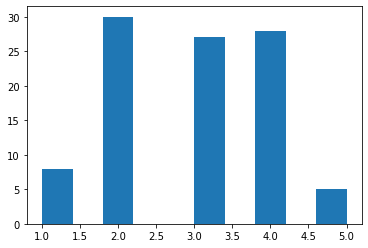

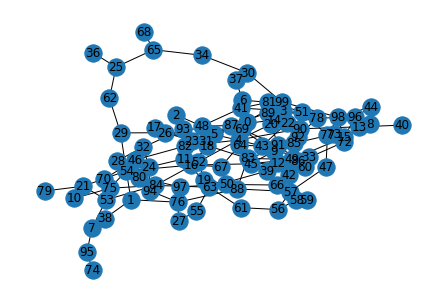

In [310]:
buildConfigModelNetwork(degreeSequence=degreesNormal)

Degree Sequence: [ 4  5  6  7  7  4  7  7  4  7  5  3  7  8 10  7  9  7  4  7 10  7  5  5
  7  5 10  4  6  8  5  4  5  4  8  9  9  9  9  7  4  4  5  9  4  4  6  7
  5 10  6  4 10  9  9  8  5  5  4  5  6  7  9  4  4  6  6  6  9  4  6  5
  4  9  3  8  9  9  7  6  5  3  8  4  8  5  8  7  5  7  4  7  7  7  5  3
  5  6  8  7]
Degree assortativity: -0.02412980582813965
Clustering coefficient: 0.06838888888888889


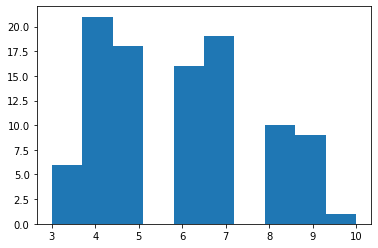

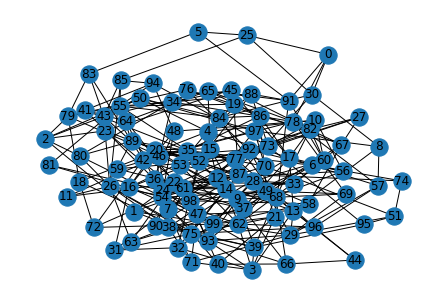

In [311]:
buildConfigModelNetwork(degreeSequence=degreesUniform)

Degree Sequence: [2, 2, 1, 1, 4, 1, 8, 1, 1, 2, 1, 2, 1, 2, 1, 2, 2, 1, 1, 1, 1, 2, 2, 4, 3, 1, 2, 1, 2, 1, 3, 1, 2, 2, 1, 4, 1, 2, 1, 3, 3, 1, 1, 1, 2, 2, 2, 3, 1, 1, 2, 4, 3, 1, 1, 1, 1, 2, 1, 1, 3, 2, 1, 2, 1, 1, 4, 1, 1, 2, 1, 1, 1, 2, 3, 1, 1, 2, 2, 1, 2, 1, 1, 3, 1, 1, 1, 4, 1, 3, 4, 4, 2, 2, 1, 3, 2, 16, 1, 2]
Degree assortativity: 0.019793541055024764
Clustering coefficient: 0.013333333333333334


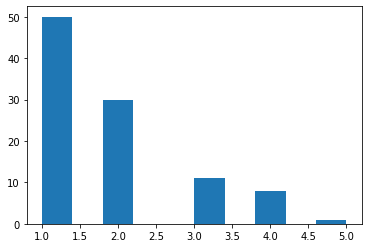

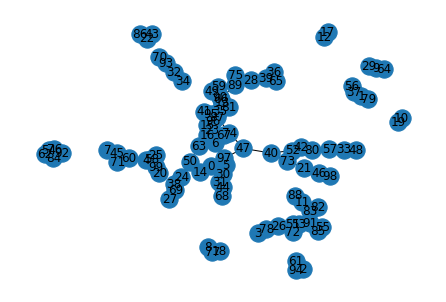

In [312]:
buildConfigModelNetwork(degreeSequence=degreesPower)

Random Walk model

In [313]:
def buildRandomWalkModel(N, m, p):
    if N < 1:
        raise Exception("Invalid parameter: N")
    
    if m < 1 or m > N:
        raise Exception("Invalid parameter: m")
    
    if p < 0 or p > 1:
        raise Exception("Invalid parameter: p") 
    
    # Create a clique of m nodes
    G = nx.complete_graph(m)
    for i in range(G.number_of_nodes(), N):
        firstAttach = np.random.choice(G.nodes)
        neighIter = nx.neighbors(G, firstAttach)
        
        # Get the list of possible neighbors of "firstAttach"
        originalNeigh = []
        for neigh in neighIter:
            originalNeigh.append(neigh)
        # Attach the new added node to the selected node
        G.add_edge(i, firstAttach)
        
        possibleNeigh = originalNeigh
        for _ in range(m - 1):    
            if np.random.uniform() < p:
                # Connect i to one of the neighbor of "firstAttach"
                if(len(possibleNeigh) > 0):
                    choiceNeigh = np.random.choice(possibleNeigh)
                    G.add_edge(i, choiceNeigh)
                    possibleNeigh = list(set(possibleNeigh).difference({choiceNeigh}))
            else: 
                # Fine the neighors of i to exclude them
                newNeigh = []
                for neigh in nx.neighbors(G, i):
                    newNeigh.append(neigh)

                # Connect i to one of the other nodes
                nodes = set(G.nodes())
                otherNodes = nodes.difference(set(originalNeigh))
                otherNodes = otherNodes.difference({i, firstAttach})
                otherNodes = otherNodes.difference(set(newNeigh))
                if(len(otherNodes) > 0) :
                    G.add_edge(i, np.random.choice(list(otherNodes)))
        
    print("Degree assortativity of RW model:", nx.degree_assortativity_coefficient(G))
    print("Clustering coefficient of RW model:", nx.average_clustering(G))
    nx.draw(G, with_labels=True)
    
    return G

Configurazione e test del Random Walk model

Degree assortativity of RW model: -0.07463091725760415
Clustering coefficient of RW model: 0.47859542240598624


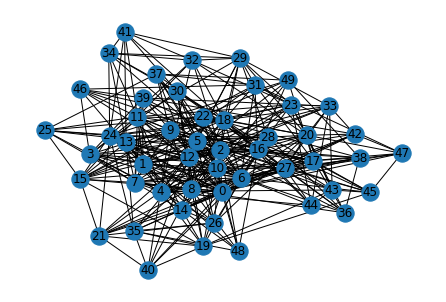

In [314]:
N = 50
m = 8
# Probability of triadic closure
p = 0.8

buildRandomWalkModel(N, m, p)

Impostando la probabilità a 0.1

Degree assortativity of RW model: 0.0640469292034252
Clustering coefficient of RW model: 0.27570828586618057


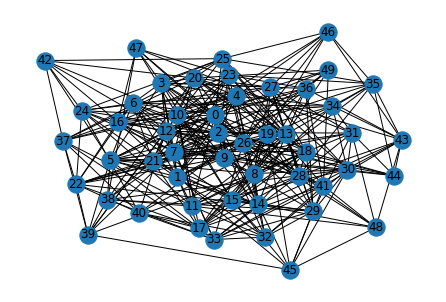

In [315]:
p = 0.1

buildRandomWalkModel(N, m, p)

Confronto con una rete generata tramite Barabasi Albert

Degree assortativity of BA graph: -0.17412781466305255
Clustering coefficient of BA graph: 0.4040231730192355
Node 0 has degree 28
Node 1 has degree 12
Node 2 has degree 22
Node 3 has degree 9
Node 4 has degree 4
Node 5 has degree 26
Node 6 has degree 14
Node 7 has degree 16
Node 8 has degree 12
Node 9 has degree 33
Node 10 has degree 29
Node 11 has degree 22
Node 12 has degree 24
Node 13 has degree 19
Node 14 has degree 20
Node 15 has degree 19
Node 16 has degree 19
Node 17 has degree 16
Node 18 has degree 14
Node 19 has degree 15
Node 20 has degree 13
Node 21 has degree 15
Node 22 has degree 12
Node 23 has degree 11
Node 24 has degree 13
Node 25 has degree 11
Node 26 has degree 11
Node 27 has degree 12
Node 28 has degree 11
Node 29 has degree 10
Node 30 has degree 10
Node 31 has degree 10
Node 32 has degree 12
Node 33 has degree 9
Node 34 has degree 10
Node 35 has degree 8
Node 36 has degree 11
Node 37 has degree 9
Node 38 has degree 10
Node 39 has degree 9
Node 40 has degree 8
Node 

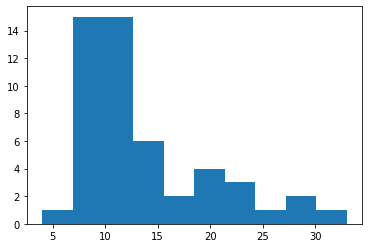

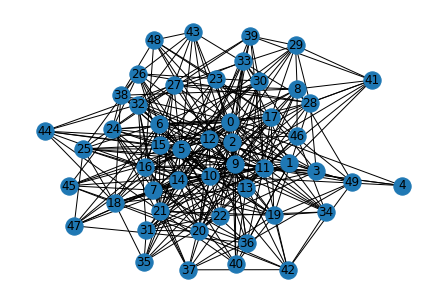

In [316]:
G = nx.barabasi_albert_graph(N,m)
print("Degree assortativity of BA graph:", nx.degree_assortativity_coefficient(G))
print("Clustering coefficient of BA graph:", nx.average_clustering(G))
printNodesDegree(G)
plotDegreeDist(G)
nx.draw(G, with_labels=True)

Fitness model 

In [317]:
def buildFitnessModel(N, m, dist):
    if N < 1:
        raise Exception("Invalid parameter: N")
    
    if m < 1 or m > N:
        raise Exception("Invalid parameter: m")
    
    if any(val < 0 for val in dist):
        raise Exception("Invalid weights distribution: must have all positive values")
        
    # Create a clique of m nodes
    G = nx.complete_graph(m)
    print("Distribution: " + dist.__str__())
    for i in range(G.number_of_nodes(), N):
        # Select m different nodes at random, weighted by their degree times the respective weight.
        newNeighbors = []
        possibleNeighbors = list(G.nodes)
        for _ in range(m):
            degrees = [dist[n] * G.degree(n) for n in possibleNeighbors]
            j = random.choices(possibleNeighbors, degrees)[0]
            newNeighbors.append(j)
            possibleNeighbors.remove(j)
        
        # Add a new node i and link it with the m nodes from the previous step.
        for j in newNeighbors:
            G.add_edge(i, j)

    print("Degree assortativity:", nx.degree_assortativity_coefficient(G))
    print("Clustering coefficient:", nx.average_clustering(G))
    printNodesDegree(G)
    plotDegreeDist(G)
    nx.draw(G, with_labels=True)
    
    return G

Configurazione e test del Fitness model

In [318]:
N = 50
m = 8
a, b = 3, 7
degreesUniform = [0] * N
degreesNormal = [0] * N
degreesPower = [0] * N

mu, sigma = 10, 1
alpha = 1.5

distNormal = np.round(np.random.normal(mu, sigma, N)).astype(int)
distUniform = np.round(np.random.uniform(a,b, size=N)).astype(int) 
distPower = nx.random_powerlaw_tree_sequence(N, tries=5000)

distYoungBias = [1] * N
for i in range(m, N):
    distYoungBias[i] = 100

Distribution: [10 11 10 11  9 10 11  8  9 10  9  9  8 11  9 10  9 12 13  9 10  9  9  9
  9 10 11  9 10  9 10 12 11  9 11 11 10  9  9  9 10 11 11 11 11  9 11  9
  9 10]
Degree assortativity: -0.13882727811118045
Clustering coefficient: 0.45199040025829634
Node 0 has degree 34
Node 1 has degree 27
Node 2 has degree 26
Node 3 has degree 24
Node 4 has degree 26
Node 5 has degree 37
Node 6 has degree 33
Node 7 has degree 24
Node 8 has degree 14
Node 9 has degree 18
Node 10 has degree 23
Node 11 has degree 14
Node 12 has degree 17
Node 13 has degree 11
Node 14 has degree 17
Node 15 has degree 19
Node 16 has degree 10
Node 17 has degree 15
Node 18 has degree 18
Node 19 has degree 14
Node 20 has degree 15
Node 21 has degree 13
Node 22 has degree 10
Node 23 has degree 12
Node 24 has degree 13
Node 25 has degree 15
Node 26 has degree 10
Node 27 has degree 12
Node 28 has degree 13
Node 29 has degree 9
Node 30 has degree 13
Node 31 has degree 12
Node 32 has degree 9
Node 33 has degree 9
Node 34 ha

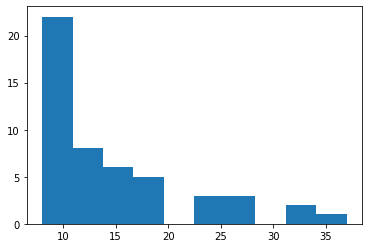

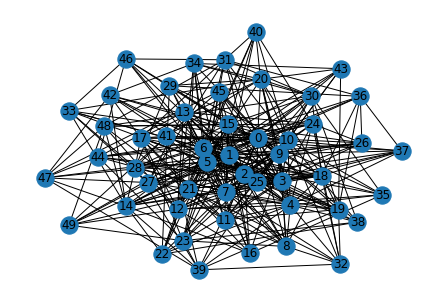

In [319]:
buildFitnessModel(N, m, distNormal)

Distribution: [4 5 4 6 5 5 5 5 4 6 4 3 5 5 4 4 5 6 5 3 6 7 5 4 6 4 4 4 4 5 3 5 5 3 5 3 5
 4 6 3 4 4 6 6 3 4 5 4 3 6]
Degree assortativity: -0.1247962314627756
Clustering coefficient: 0.4364665582906712
Node 0 has degree 24
Node 1 has degree 25
Node 2 has degree 19
Node 3 has degree 24
Node 4 has degree 28
Node 5 has degree 24
Node 6 has degree 29
Node 7 has degree 24
Node 8 has degree 26
Node 9 has degree 30
Node 10 has degree 13
Node 11 has degree 10
Node 12 has degree 19
Node 13 has degree 20
Node 14 has degree 17
Node 15 has degree 22
Node 16 has degree 22
Node 17 has degree 11
Node 18 has degree 21
Node 19 has degree 8
Node 20 has degree 12
Node 21 has degree 14
Node 22 has degree 13
Node 23 has degree 18
Node 24 has degree 13
Node 25 has degree 15
Node 26 has degree 11
Node 27 has degree 16
Node 28 has degree 11
Node 29 has degree 11
Node 30 has degree 13
Node 31 has degree 9
Node 32 has degree 9
Node 33 has degree 8
Node 34 has degree 11
Node 35 has degree 10
Node 36 has degree 1

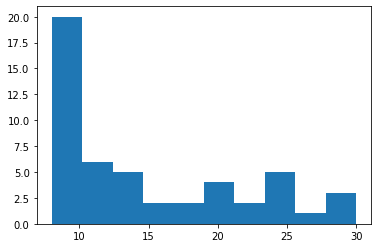

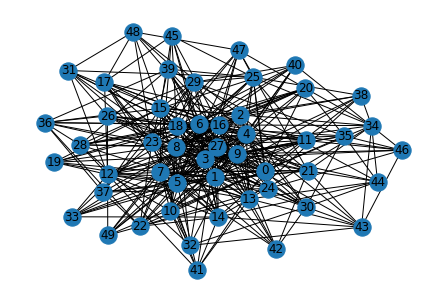

In [320]:
buildFitnessModel(N, m, distUniform)

Distribution: [2, 3, 5, 1, 1, 2, 2, 2, 1, 1, 2, 1, 1, 1, 2, 1, 2, 1, 2, 1, 1, 5, 1, 1, 1, 1, 2, 2, 1, 3, 1, 1, 1, 13, 1, 1, 2, 1, 1, 2, 1, 8, 1, 1, 2, 1, 5, 1, 1, 1]
Degree assortativity: -0.19250209368343466
Clustering coefficient: 0.43950988398856267
Node 0 has degree 27
Node 1 has degree 30
Node 2 has degree 40
Node 3 has degree 18
Node 4 has degree 19
Node 5 has degree 28
Node 6 has degree 26
Node 7 has degree 23
Node 8 has degree 20
Node 9 has degree 22
Node 10 has degree 17
Node 11 has degree 16
Node 12 has degree 12
Node 13 has degree 20
Node 14 has degree 22
Node 15 has degree 13
Node 16 has degree 19
Node 17 has degree 10
Node 18 has degree 15
Node 19 has degree 12
Node 20 has degree 12
Node 21 has degree 28
Node 22 has degree 11
Node 23 has degree 9
Node 24 has degree 11
Node 25 has degree 9
Node 26 has degree 12
Node 27 has degree 15
Node 28 has degree 10
Node 29 has degree 19
Node 30 has degree 9
Node 31 has degree 8
Node 32 has degree 10
Node 33 has degree 18
Node 34 has d

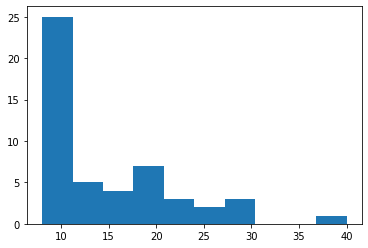

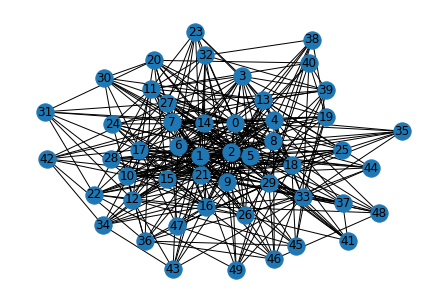

In [321]:
buildFitnessModel(N, m, distPower)

Distribution: [1, 1, 1, 1, 1, 1, 1, 1, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100]
Degree assortativity: -0.19326564284121012
Clustering coefficient: 0.5552635878187707
Node 0 has degree 12
Node 1 has degree 12
Node 2 has degree 11
Node 3 has degree 10
Node 4 has degree 11
Node 5 has degree 13
Node 6 has degree 11
Node 7 has degree 14
Node 8 has degree 35
Node 9 has degree 36
Node 10 has degree 30
Node 11 has degree 32
Node 12 has degree 31
Node 13 has degree 29
Node 14 has degree 23
Node 15 has degree 19
Node 16 has degree 29
Node 17 has degree 23
Node 18 has degree 13
Node 19 has degree 20
Node 20 has degree 14
Node 21 has degree 19
Node 22 has degree 12
Node 23 has degree 14
Node 24 has degree 13
Node 25 has degree 13
Node 26 has degree 12
Node 27 has degree 12
Node 28 has degree 9
Node 29 has degree 11
Node 30 has degr

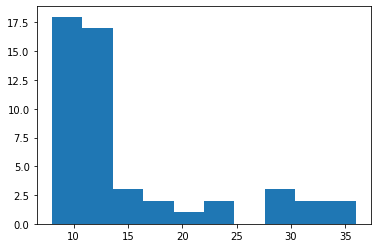

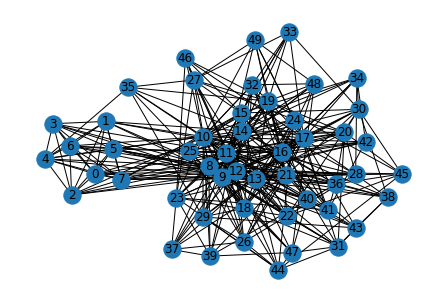

In [322]:
buildFitnessModel(N, m, distYoungBias)